In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import time
import datetime 
%matplotlib inline  
import sys
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/jz2308/bus-Capstone')

# these two modules are homemade
import gtfs
import arrivals
import ttools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

In [2]:
base = datetime.date(2015, 1, 1)
schedule_samples = [str(base + datetime.timedelta(days=x)) for x in range(0, 365)]
#schedule_samples = ['2015-01-04','2015-04-05','2015-06-27','2015-07-06','2015-09-05','2015-09-15','2015-10-12']
collected = pd.DataFrame()
for sdate in schedule_samples[0:1]:
    stops = gtfs.load_stops(sdate,'gtfs/')
    stops['schedule_sample_date'] = sdate
    collected = collected.append(stops[['stop_lat','stop_lon','stop_name','schedule_sample_date']].drop_duplicates())

In [3]:
collected.reset_index().head()

,stop_id,stop_lat,stop_lon,stop_name,schedule_sample_date
0,300000,40.578209,-73.939697,ORIENTAL BL/MACKENZIE ST,2015-01-01
1,300002,40.578068,-73.943031,ORIENTAL BL/JAFFRAY ST,2015-01-01
2,300003,40.577961,-73.944664,ORIENTAL BL/HASTINGS ST,2015-01-01
3,300004,40.577721,-73.946205,ORIENTAL BL/FALMOUTH ST,2015-01-01
4,300006,40.577354,-73.949554,ORIENTAL BL/DOVER ST,2015-01-01


In [4]:
collected.reset_index().head()

,stop_id,stop_lat,stop_lon,stop_name,schedule_sample_date
0,300000,40.578209,-73.939697,ORIENTAL BL/MACKENZIE ST,2015-01-01
1,300002,40.578068,-73.943031,ORIENTAL BL/JAFFRAY ST,2015-01-01
2,300003,40.577961,-73.944664,ORIENTAL BL/HASTINGS ST,2015-01-01
3,300004,40.577721,-73.946205,ORIENTAL BL/FALMOUTH ST,2015-01-01
4,300006,40.577354,-73.949554,ORIENTAL BL/DOVER ST,2015-01-01


In [5]:
reliability_metrics = pd.read_csv('performance.csv',names = ["Line", "stop_id", "schedule_sample_date", "ontime_ratio", "peak_hours wait ass","offpeak hours wait ass"])

In [6]:
reliability_metrics['peak_hours wait ass'].replace('None', None, inplace=True)

In [7]:
pd.DataFrame(reliability_metrics.reset_index().groupby('stop_id').mean().reset_index()).head()

,stop_id,index,ontime_ratio,offpeak hours wait ass
0,100014,2228436,0.139963,0.921871
1,100017,3101092,0.210164,0.913365
2,100018,3631244,0.177457,0.892479
3,100019,3116986,0.203798,0.918004
4,100020,2587259,0.203381,0.854682


In [8]:
stops_metrics = collected.reset_index().merge(pd.DataFrame(reliability_metrics.reset_index().groupby('stop_id').mean().reset_index()))
stops_metrics = stops_metrics.groupby('stop_id').mean()[['stop_lat','stop_lon','ontime_ratio','offpeak hours wait ass']]

In [9]:
stops_metrics.head()

,stop_lat,stop_lon,ontime_ratio,offpeak hours wait ass
stop_id,,,,
100014,40.872562,-73.888153,0.139963,0.921871
100017,40.876808,-73.889656,0.210164,0.913365
100018,40.880341,-73.886063,0.177457,0.892479
100019,40.813496,-73.929489,0.203798,0.918004
100020,40.816803,-73.927956,0.203381,0.854682


In [10]:
stops_metrics.to_csv('metrics-by-stop-2015.csv')

In [23]:
# get all the schedule data. (subset can be created later)
trips = gtfs.load_trips('2015-12-03','gtfs/')
# stops = gtfs.load_stops('2015-12-03','gtfs/')
stop_times, tz_sched = gtfs.load_stop_times('2015-12-03','gtfs/')
print 'Finished loading GTFS data.'
joined = stop_times.reset_index(level=1)[['stop_id','stop_sequence']].join(trips[['route_id','direction_id']])
unique_stops = joined.reset_index().drop_duplicates(subset=['route_id','direction_id','stop_id','stop_sequence']).drop('trip_id',axis=1)
unique_stops = unique_stops.set_index(['route_id','stop_id'],verify_integrity=False)
dupe_inds = unique_stops.index[unique_stops.index.duplicated()]
unique_stops = unique_stops.loc[dupe_inds]

Finished loading GTFS data.


In [27]:
unique_stops

stop_sequence  direction_id
route_id stop_id                             
BX23     150139              24             1
         150139               1             0
         150139               2             1
         150038               1             1
         150038              23             0
Q50      101734              27             0
         101734               1             1
BXM9     103561               1             1
         103561              19             0
BXM7     103674               1             1
         103674              14             0
BXM6     103294              11             0
         103294               1             1
BXM4     150151               1             1
         150151              30             0
Q37      551203              15             0
         551203              16             0
         551203               2             0
         551205              16             0
         551205              17             0
         551205               3             0
         551207              17             0
         551207              18             0
         551207               4             0
         551211              18             0
         551211              19             0
         551211               5             0
         551213              19             0
         551213              20             0
         551213               6             0
...                         ...           ...
S44      200858               5             0
         200858              52             0
         200858              48             0
         200040               6             0
         200040              53             0
         200040              49             0
         200041               7             0
         200041              54             0
         200041              50             0
         200042               8             0
         200042              55             0
         200042              51             0
         200043               9             0
         200043              56             0
         200043              52             0
         200044              10             0
         200044              57             0
         200044              53             0
         200045              11             0
         200045              58             0
         200045              54             0
         200046              12             0
         200046              59             0
         200046              55             0
         200047              13             0
         200047              60             0
         200047              56             0
         805016              14             0
         805016              61             0
         805016              57             0

[63226 rows x 2 columns]

In [25]:
collected.head()

,stop_id_left,stop_lat,stop_lon,stop_name,schedule_sample_date,route_id,stop_id_right,stop_sequence,direction_id
0,300000,40.578209,-73.939697,ORIENTAL BL/MACKENZIE ST,2015-01-01,BX23,150139,24,1
1,300002,40.578068,-73.943031,ORIENTAL BL/JAFFRAY ST,2015-01-01,BX23,150139,1,0
2,300003,40.577961,-73.944664,ORIENTAL BL/HASTINGS ST,2015-01-01,BX23,150139,2,1
3,300004,40.577721,-73.946205,ORIENTAL BL/FALMOUTH ST,2015-01-01,BX23,150038,1,1
4,300006,40.577354,-73.949554,ORIENTAL BL/DOVER ST,2015-01-01,BX23,150038,23,0


In [12]:
collected = collected.reset_index().join(unique_stops.reset_index(),how='left',lsuffix='_left', rsuffix='_right')

In [13]:
collected.route_id.unique()

array(['BX23', 'Q50', 'BXM9', 'BXM7', 'BXM6', 'BXM4', 'Q37', 'Q41', 'Q06',
       'Q07', 'Q08', 'Q09', 'Q60', 'Q10', 'Q21', 'Q11', 'QM18', 'QM15',
       'Q22', 'QM17', 'QM16', 'Q35', 'Q52', 'Q53', 'Q25', 'Q34', 'QM20',
       'QM11', 'QM10', 'QM8', 'QM7', 'QM6', 'QM5', 'QM4', 'QM3', 'QM2',
       'QM1', 'Q66', 'Q65', 'Q38', 'QM12', 'Q33', 'Q103', 'QM25', 'QM24',
       'Q104', 'Q102', 'Q101', 'Q100', 'Q72', 'Q69', 'Q49', 'Q47', 'Q39',
       'Q29', 'Q23', 'Q18', 'Q114', 'Q111', 'Q64', 'Q112', 'Q110', 'QM21',
       'B103', 'BM5', 'BM2', 'B100', 'BM1', 'BXM8', 'BXM1', 'BXM2', 'BXM3',
       'BM3', 'BM4', 'S52', 'S51', 'X10', 'S46', 'S40', 'S96', 'S48',
       'X12', 'X21', 'S66', 'S78', 'S42', 'S53', 'S76', 'S54', 'S57', 'S74'], dtype=object)

In [14]:
line_metrics = collected.reset_index().join((pd.DataFrame(reliability_metrics.groupby(['Line','stop_id']).mean().reset_index())),how='left',lsuffix='_left', rsuffix='_right')

In [15]:
line_metrics.head()

,index,stop_id_left,stop_lat,stop_lon,stop_name,schedule_sample_date,route_id,stop_id_right,stop_sequence,direction_id,Line,stop_id,ontime_ratio,offpeak hours wait ass
0,0,300000,40.578209,-73.939697,ORIENTAL BL/MACKENZIE ST,2015-01-01,BX23,150139,24,1,B1,300000,0.153516,0.921430
1,1,300002,40.578068,-73.943031,ORIENTAL BL/JAFFRAY ST,2015-01-01,BX23,150139,1,0,B1,300002,0.154064,0.889592
2,2,300003,40.577961,-73.944664,ORIENTAL BL/HASTINGS ST,2015-01-01,BX23,150139,2,1,B1,300003,0.226618,0.900917
3,3,300004,40.577721,-73.946205,ORIENTAL BL/FALMOUTH ST,2015-01-01,BX23,150038,1,1,B1,300004,0.226554,0.918115
4,4,300006,40.577354,-73.949554,ORIENTAL BL/DOVER ST,2015-01-01,BX23,150038,23,0,B1,300006,0.202300,0.917007


In [16]:
line_metrics.query("Line=='B1' and direction_id==1").to_csv('metrics-by-line-stop-B1-1-2015.csv')

In [17]:
line_metrics.query("Line=='B1' and direction_id==0").to_csv('metrics-by-line-stop-B1-0-2015.csv')

In [18]:
line_metrics.query("Line=='M5' and direction_id==1").to_csv('metrics-by-line-stop-M5-1-2015.csv')

In [20]:
line_metrics.query("Line=='M5' and direction_id==0").to_csv('metrics-by-line-stop-M5-0-2015.csv')

In [22]:
line_metrics.query("Line=='M15' and direction_id==0").to_csv('metrics-by-line-stop-M15-0-2015.csv')

In [21]:
line_metrics.query("Line=='M15' and direction_id==1").to_csv('metrics-by-line-stop-M15-1-2015.csv')

/opt/rh/anaconda/root/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


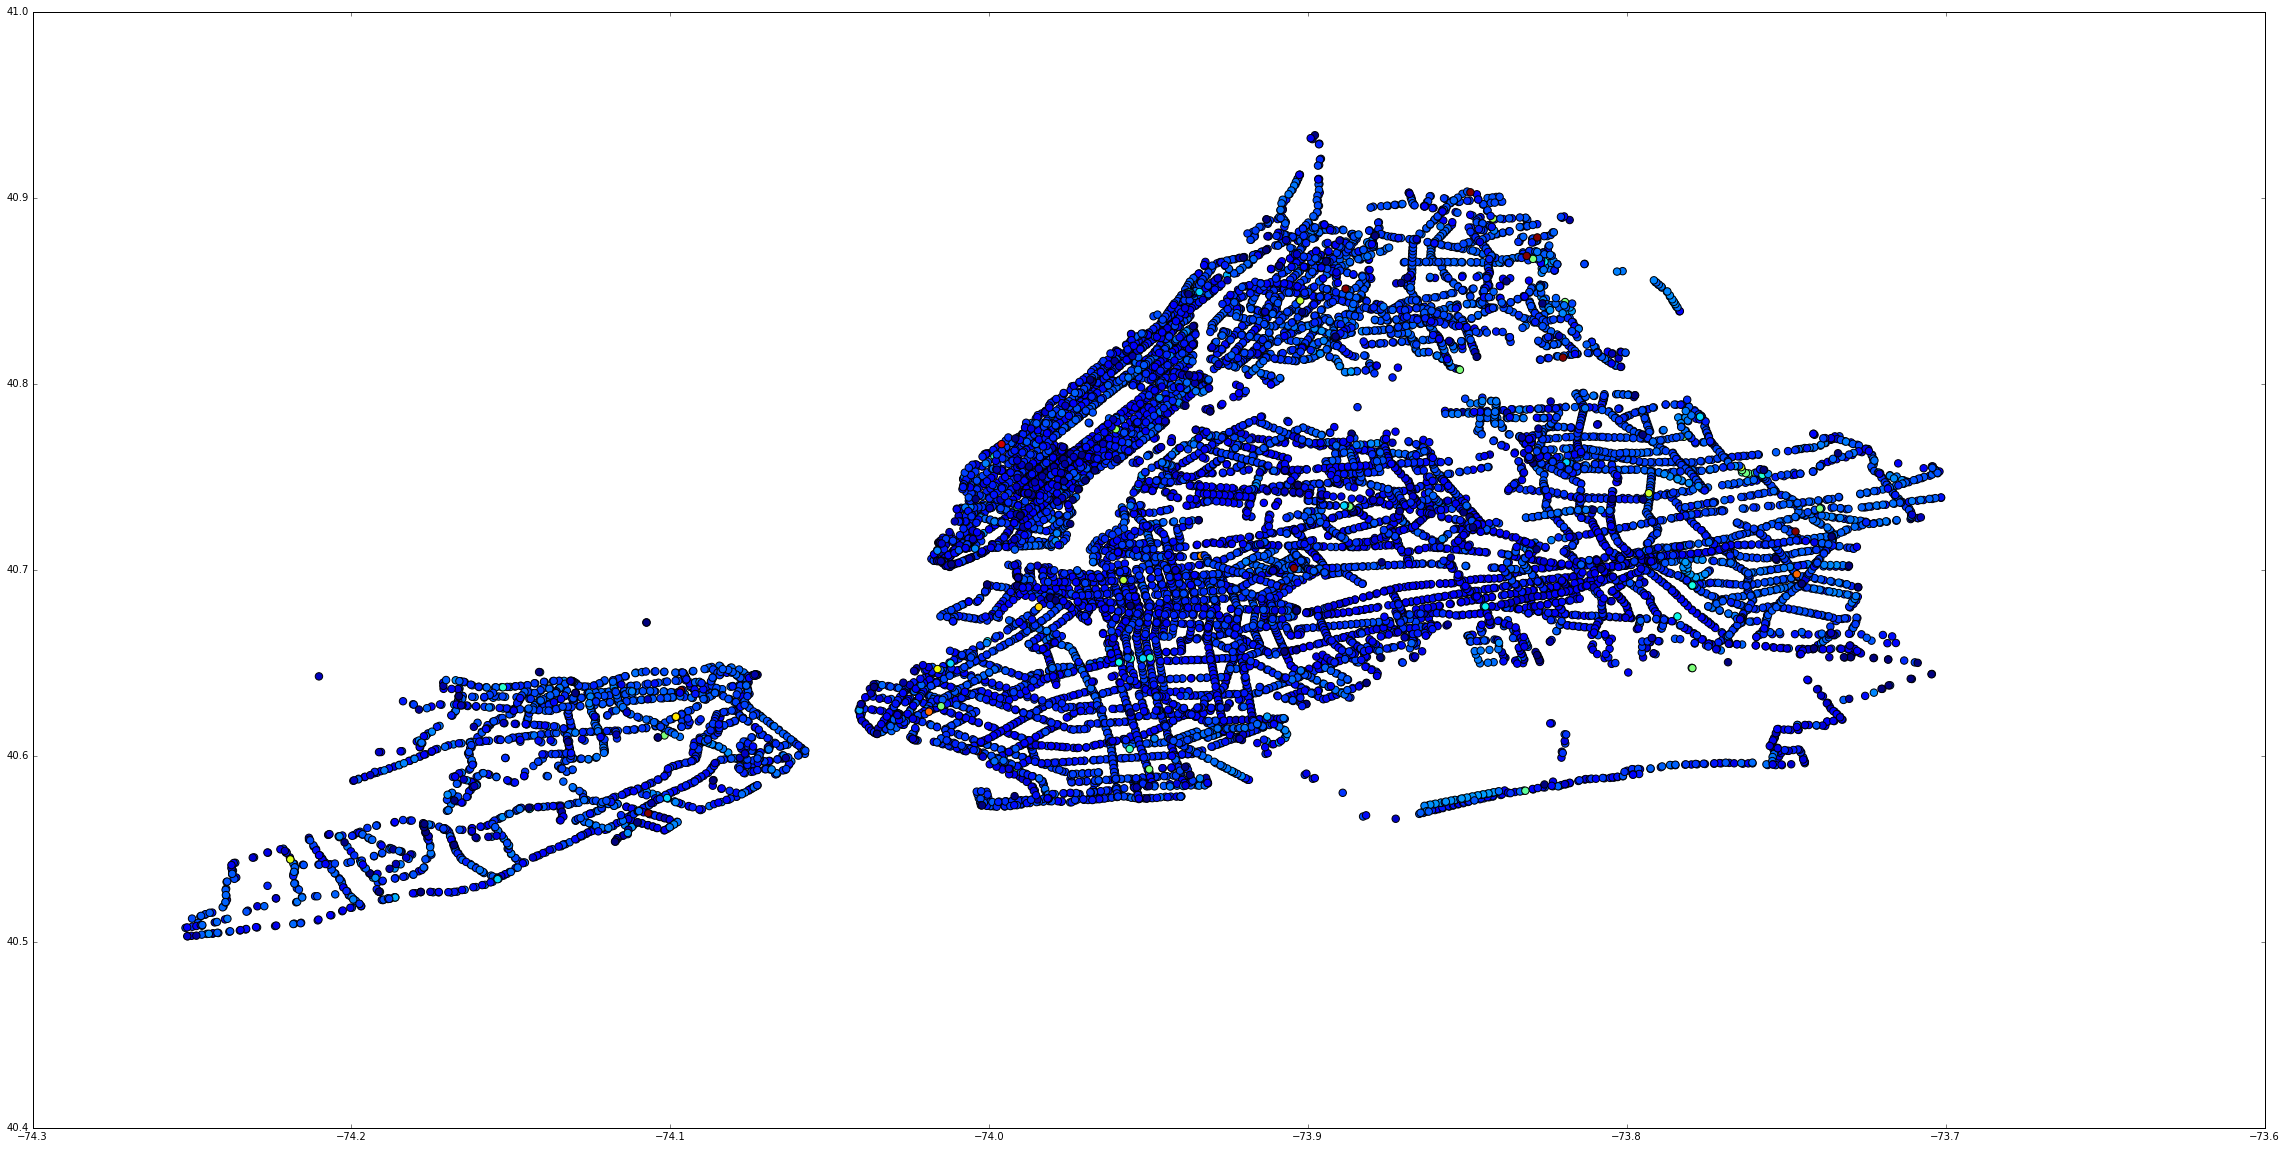

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,20))
plt.scatter(stops_metrics.stop_lon,stops_metrics.stop_lat,c=stops_metrics.ontime_ratio,s=55)
